### Let's look at the 38 classes of finnish traffic signs (Altered SVG files) - available in dataset shared by previous researcher from Jamk - (Joona Tenhunen)

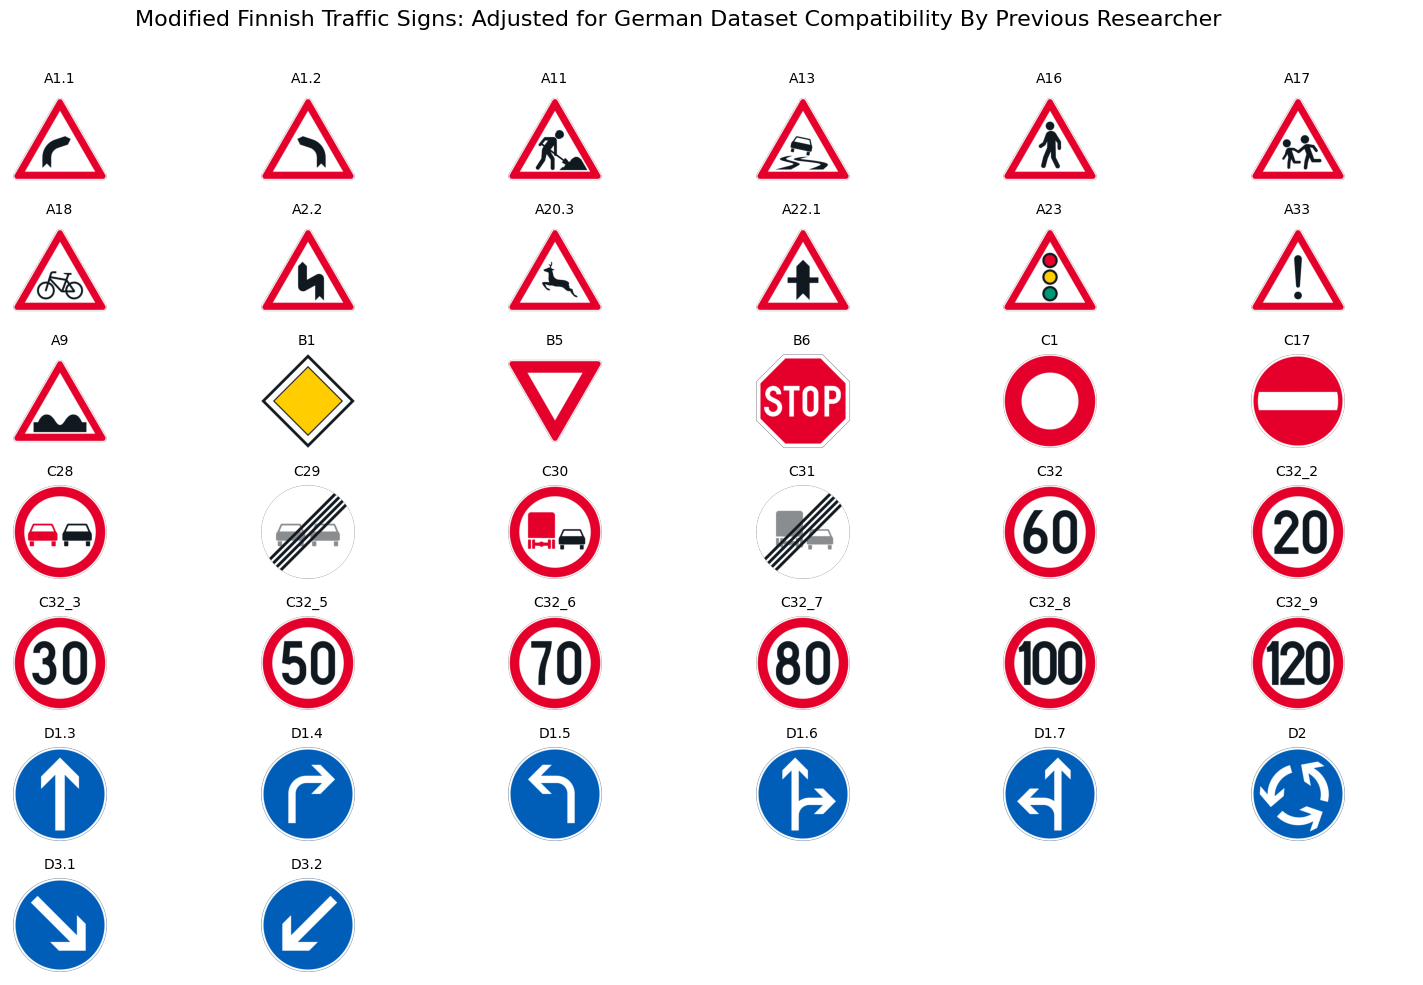

In [5]:
import os
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.image import imread
from cairosvg import svg2png
from io import BytesIO

# Path to the folder containing SVG files 38 classes - Old Dataset
svg_folder = r'C:\Users\ali\Documents\jamk\thesis\mika_shared_dataset\merkit_valkoiset'

# List of traffic sign classes
traffic_sign_classes = [
    'A1.1', 'A1.2', 'A11', 'A13', 'A16', 'A17', 'A18', 'A2.2', 'A20.3', 
    'A22.1', 'A23', 'A33', 'A9', 'B1', 'B5', 'B6', 'C1', 'C17', 'C28', 
    'C29', 'C30', 'C31', 'C32', 'C32_2', 'C32_3', 'C32_5', 'C32_6', 
    'C32_7', 'C32_8', 'C32_9', 'D1.3', 'D1.4', 'D1.5', 'D1.6', 'D1.7', 
    'D2', 'D3.1', 'D3.2'
]

# Prepare the figure for a collage
n_cols = 6  # Number of columns in the collage
n_rows = -(-len(traffic_sign_classes) // n_cols)  # Calculate rows dynamically
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Iterate through traffic sign classes and corresponding axes
for idx, (cls, ax) in enumerate(zip(traffic_sign_classes, axes)):
    # Path to the SVG file
    svg_path = os.path.join(svg_folder, f"{cls}.svg")
    
    if os.path.exists(svg_path):
        # Convert SVG to PNG for rendering
        png_data = BytesIO()
        svg2png(url=svg_path, write_to=png_data)
        img = imread(BytesIO(png_data.getvalue()))
        
        # Display the image
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(cls, fontsize=10, pad=5)
    else:
        # If the SVG file doesn't exist, leave the space empty
        ax.axis('off')
        ax.set_title(f"{cls} (Missing)", fontsize=10, pad=5, color='red')

# Turn off any remaining empty axes
for ax in axes[len(traffic_sign_classes):]:
    ax.axis('off')

# Add a title to the collage
plt.suptitle('Modified Finnish Traffic Signs: Adjusted for German Dataset Compatibility By Previous Researcher', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Let's look at the class distribution with distortion variations

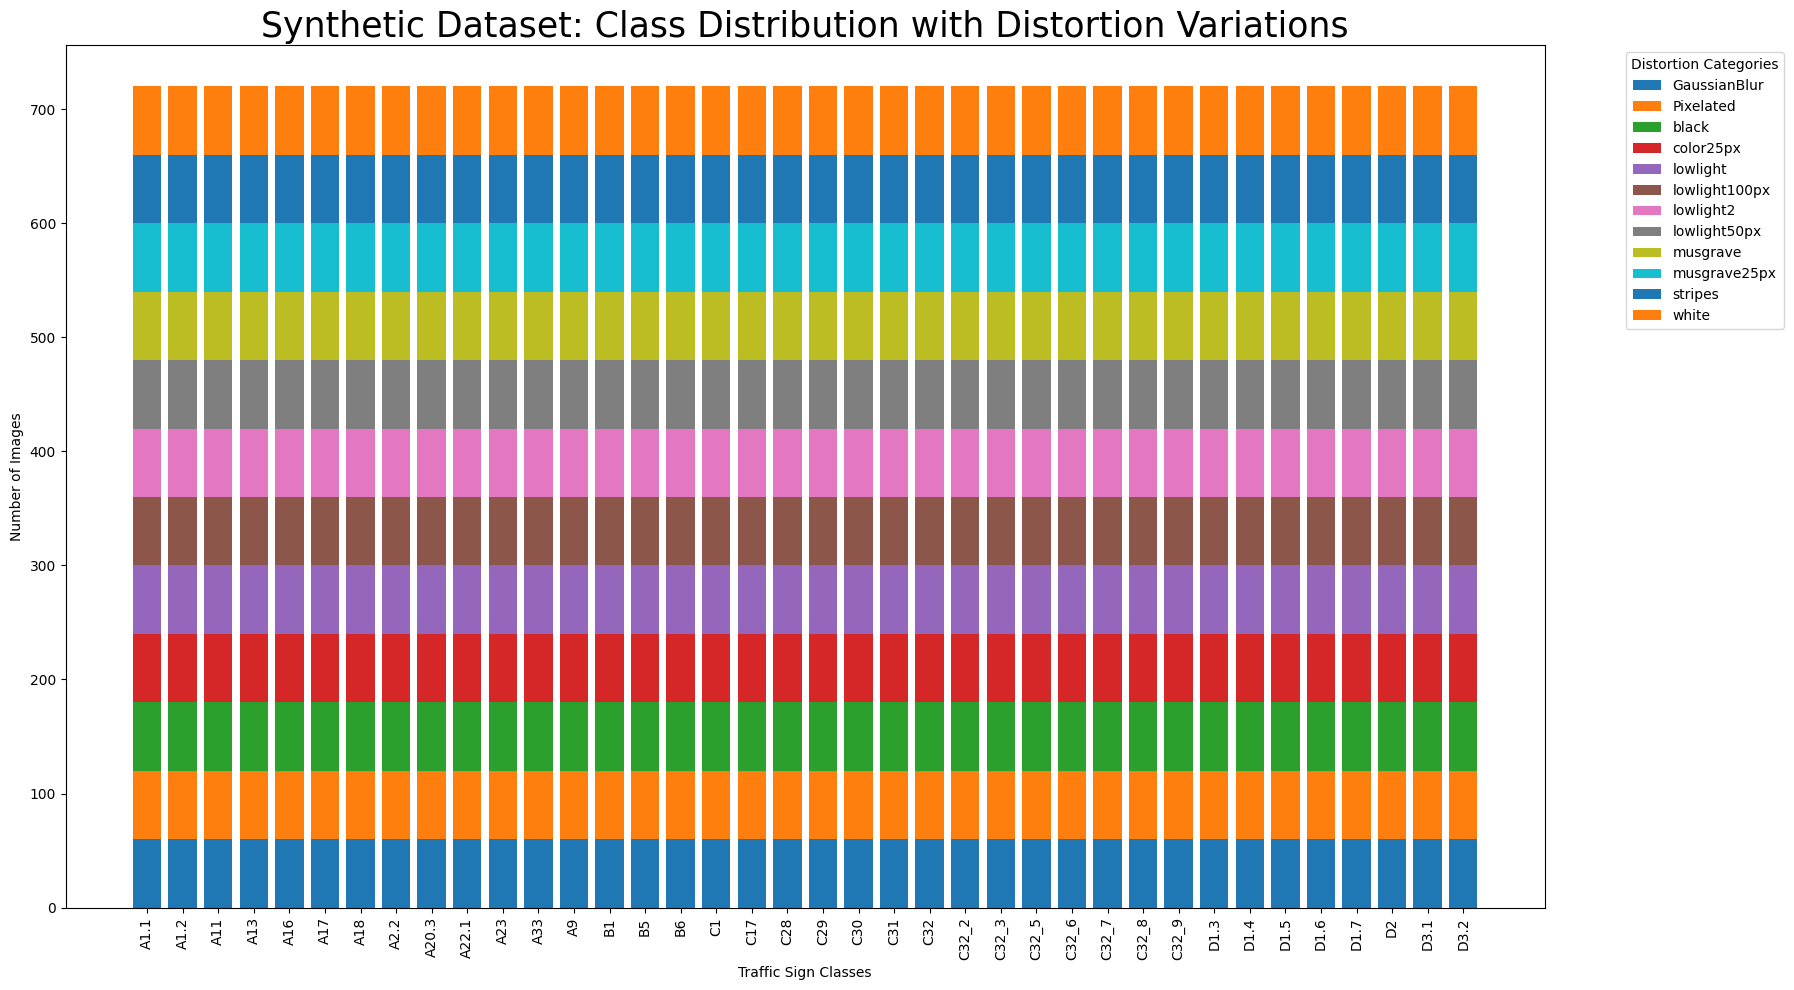

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def generate_dataset_info(dataset_path):
    """
    Function to parse the dataset folder and generate information on classes and variations.
    :param dataset_path: Path to the dataset folder
    :return: DataFrame with class, category, and count information
    """
    data = []

    # Iterate over classes (top-level folders)
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            
            # Iterate over variations (subfolders within class folders)
            for variation_name in os.listdir(class_path):
                variation_path = os.path.join(class_path, variation_name)
                if os.path.isdir(variation_path):
                    
                    # Count the number of images/files in the variation folder
                    file_count = len([f for f in os.listdir(variation_path) if os.path.isfile(os.path.join(variation_path, f))])
                    
                    # Append the data
                    data.append({'Class': class_name, 'Category': variation_name, 'Count': file_count})

    # Create a DataFrame
    return pd.DataFrame(data)

# Dataset Path
dataset_path = r"C:\Users\ali\workspace\jamk_thesis\thesis_work\dataset\mika_shared_dataset\38"

# Generate dataset information
df = generate_dataset_info(dataset_path)

# Pivot the DataFrame for Stacked Bar Chart
pivot_data = df.pivot(index='Class', columns='Category', values='Count').fillna(0)

# Plotting the Stacked Bar Chart
plt.figure(figsize=(18, 10))
bottom_values = np.zeros(len(pivot_data.index))

# Iterate over categories to stack bars
for category in pivot_data.columns:
    plt.bar(
        pivot_data.index, 
        pivot_data[category], 
        bottom=bottom_values, 
        label=category
    )
    bottom_values += pivot_data[category]

# Add Labels and Legend
plt.xticks(rotation=90)
plt.xlabel('Traffic Sign Classes')
plt.ylabel('Number of Images')
plt.title('Synthetic Dataset: Class Distribution with Distortion Variations', fontsize=25)
plt.legend(title='Distortion Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

## Let's structure the dataset for model training

In [7]:
import os
import json
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import re

def sanitize_filename(filename):
    # Replace any character that is not alphanumeric, underscore, hyphen, or dot
    return re.sub(r'[^\w\.-]', '_', filename)

# Set the base directory and train/test directories
base_dir =  r"C:\Users\ali\workspace\jamk_thesis\thesis_work\dataset\mika_shared_dataset\38"
output_dir = r'D:\dataset\structhured_dataset_38_classes'
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Create train and test directories outside the "38_classes" folder
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Lists to hold image file paths and labels for the CSV files
train_data = []
test_data = []
class_label_Id_mapping_dict = {}
train_classes = []
test_classes = []

# Counter for unique filenames
unique_counter = 0
class_counter = -1

# Traverse through all subdirectories and files in the base directory
for root, dirs, files in os.walk(base_dir):
    # Filter for image files (e.g., .jpg, .jpeg, .png, .svg)
    images = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.svg'))]
    
    # If there are images in the directory, process them
    if images:
        # Split images into train and test sets
        train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)
        
        # Get the class label from the class directory
        # The class label is the parent directory of the current directory
        class_label = os.path.basename(os.path.dirname(root))
        class_label_sanitized = sanitize_filename(class_label)
        
        # Get the subdirectory name
        sub_dir = os.path.basename(root)
        sub_dir_sanitized = sanitize_filename(sub_dir)
        
        # Process and copy the train images
        for img_name in train_images:
            src_path = os.path.join(root, img_name)
            img_name_sanitized = sanitize_filename(img_name)
            
            if class_label not in train_classes:
                class_counter+=1
                train_classes.append(class_label)
                class_label_Id_mapping_dict[class_counter] = class_label
                dst_dirs = os.path.join(train_dir, f"{class_counter}")
                os.makedirs(dst_dirs, exist_ok=True)

            # Create a unique filename
            unique_filename = f"{train_classes.index(class_label)}/{class_label_sanitized}_{sub_dir_sanitized}_{img_name_sanitized}"

            # Check for filename collision
            dst_path = os.path.join(train_dir, f"{unique_filename}")
            if os.path.exists(dst_path):
                unique_counter += 1
                name, ext = os.path.splitext(unique_filename)
                unique_filename = f"{train_classes.index(class_label)}/{name}_{unique_counter}{ext}"
                dst_path = os.path.join(train_dir, unique_filename)
            
            # Copy the image and record the data
            shutil.move(src_path, dst_path)
            train_data.append({'filename': unique_filename, 'class': class_label, 'classId': train_classes.index(class_label)})
        
        # Process and copy the test images
        for img_name in test_images:
            src_path = os.path.join(root, img_name)
            img_name_sanitized = sanitize_filename(img_name)

            if class_label not in test_classes:
                test_classes.append(class_label)
            
            # Create a unique filename
            unique_filename = f"{class_label_sanitized}_{sub_dir_sanitized}_{img_name_sanitized}"
            
            # Check for filename collision
            dst_path = os.path.join(test_dir, unique_filename)
            if os.path.exists(dst_path):
                unique_counter += 1
                name, ext = os.path.splitext(unique_filename)
                unique_filename = f"{name}_{unique_counter}{ext}"
                dst_path = os.path.join(test_dir, unique_filename)
            
            # Copy the image and record the data
            shutil.move(src_path, dst_path)
            test_data.append({'filename': unique_filename, 'class': class_label, 'classId': test_classes.index(class_label)})

# Create DataFrames for train and test data
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Save the DataFrames to CSV files outside the "38_classes" folder
train_csv_path = os.path.join(output_dir, 'Train.csv')
test_csv_path = os.path.join(output_dir, 'Test.csv')
train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"Train and test split completed. CSV files created at {train_csv_path} and {test_csv_path}.")

print(json.dumps(class_label_Id_mapping_dict))

Train and test split completed. CSV files created at D:\dataset\structhured_dataset_38_classes\Train.csv and D:\dataset\structhured_dataset_38_classes\Test.csv.
{"0": "A1.1", "1": "A1.2", "2": "A11", "3": "A13", "4": "A16", "5": "A17", "6": "A18", "7": "A2.2", "8": "A20.3", "9": "A22.1", "10": "A23", "11": "A33", "12": "A9", "13": "B1", "14": "B5", "15": "B6", "16": "C1", "17": "C17", "18": "C28", "19": "C29", "20": "C30", "21": "C31", "22": "C32", "23": "C32_2", "24": "C32_3", "25": "C32_5", "26": "C32_6", "27": "C32_7", "28": "C32_8", "29": "C32_9", "30": "D1.3", "31": "D1.4", "32": "D1.5", "33": "D1.6", "34": "D1.7", "35": "D2", "36": "D3.1", "37": "D3.2"}


#### Dataset size - 26.7 GB 

## Model Training

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [58]:
# Setting variables for later use
data = []
labels = []
classes = 38
cur_path = os.getcwd()

# Retrieving the images and their labels
for i in range(classes):
    path = os.path.join(r"D:\dataset\structhured_dataset_38_classes\\", "Train", str(i))

    # Check if the folder exists
    if not os.path.exists(path):
        print(f"Folder {path} does not exist. Skipping class {i}.")
        continue  # Skip this iteration if folder does not exist as we have less classes for Finnish dataset

    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            image = image.resize((100,100))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except Exception as e:
            print(f"Error loading image {a}: {e}")

# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

In [61]:
# Checking data shape
print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 38)
y_test = to_categorical(y_test, 38)

(19152, 100, 100, 3) (19152,)
(15321, 100, 100, 3) (3831, 100, 100, 3) (15321,) (3831,)


In [62]:
# Building the model
model = Sequential()

# Step 1: Conv2D filters
model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Step 2: Dropout to prevent overfitting
model.add(Dropout(rate=0.25))

# Step 3: Fewer Conv2D layers but not oversimplified
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Dropout to ensure regularization
model.add(Dropout(rate=0.25))

# Step 4: Flatten and reduce dense layer size
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))

# Output layer with 38 classes
model.add(Dense(38, activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model display
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 96, 96, 16)          │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 92, 92, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 46, 46, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 46, 46, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 44, 44, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       1,982,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,999,766 (7.63 MB)

 Trainable params: 1,999,766 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Training the Model
with tf.device('/GPU:0'):
    epochs = 35
    history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/35
479/479 ━━━━━━━━━━━━━━━━━━━━ 87s 137ms/step - accuracy: 0.0856 - loss: 5.1696 - val_accuracy: 0.6502 - val_loss: 1.5008
Epoch 2/35
479/479 ━━━━━━━━━━━━━━━━━━━━ 60s 125ms/step - accuracy: 0.3168 - loss: 2.1531 - val_accuracy: 0.8121 - val_loss: 0.8356
Epoch 3/35
479/479 ━━━━━━━━━━━━━━━━━━━━ 56s 116ms/step - accuracy: 0.4155 - loss: 1.7143 - val_accuracy: 0.9225 - val_loss: 0.4896
Epoch 4/35
479/479 ━━━━━━━━━━━━━━━━━━━━ 56s 117ms/step - accuracy: 0.5003 - loss: 1.4441 - val_accuracy: 0.9504 - val_loss: 0.3467
Epoch 5/35
479/479 ━━━━━━━━━━━━━━━━━━━━ 56s 117ms/step - accuracy: 0.5341 - loss: 1.3075 - val_accuracy: 0.9627 - val_loss: 0.2965
Epoch 6/35
479/479 ━━━━━━━━━━━━━━━━━━━━ 57s 119ms/step - accuracy: 0.5703 - loss: 1.2411 - val_accuracy: 0.9658 - val_loss: 0.2341
Epoch 7/35
479/479 ━━━━━━━━━━━━━━━━━━━━ 57s 119ms/step - accuracy: 0.5771 - loss: 1.2081 - val_accuracy: 0.9470 - val_loss: 0.2260
Epoch 8/35
479/479 ━━━━━━━━━━━━━━━━━━━━ 56s 117ms/step - accuracy: 0.5916 - loss: 1

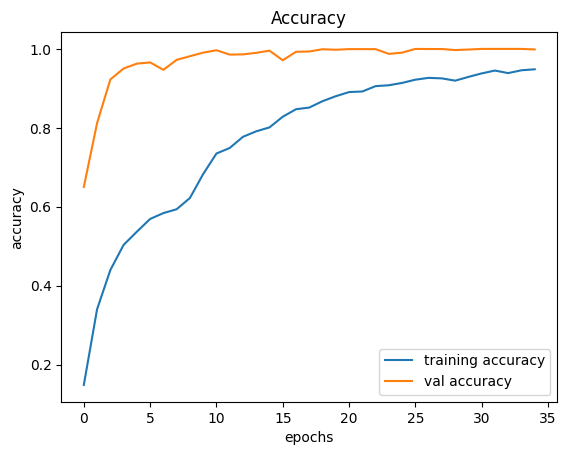

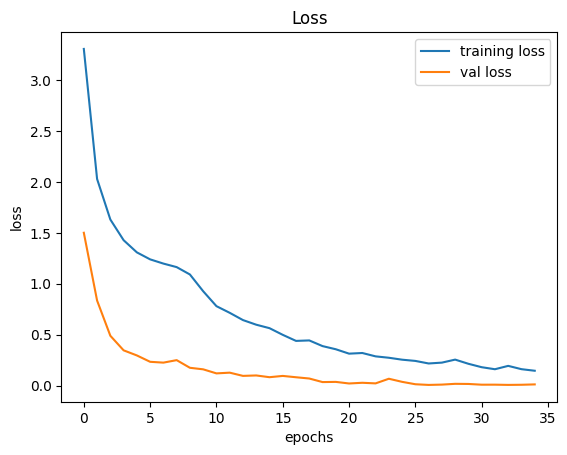

In [64]:
# Plotting performance graphs
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [65]:
# testing accuracy on test dataset
from sklearn.metrics import accuracy_score

# Importing the test dataset
y_test = pd.read_csv(r"D:\dataset\structhured_dataset_38_classes\\Test.csv")

labels = y_test["classId"].values
imgs = y_test["filename"].values

data=[]

# Retreiving the images
with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open(r"D:\dataset\structhured_dataset_38_classes\test\\"+img)
        image = image.resize([100, 100])
        data.append(np.array(image))

X_test=np.array(data)

with tf.device('/GPU:0'):
    pred = np.argmax(model.predict(X_test), axis=-1)

print(accuracy_score(labels, pred))

257/257 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step
0.998172514619883


In [72]:
# Saving the Model
model.save(r"D:\dataset\structhured_dataset_38_classes\\finnish_traffic_sign_classifier_38_classes_old_dataset.keras")

In [66]:
# Mapping of Class IDs to Traffic Sign Classes
class_labels = {"0": "A1.1", "1": "A1.2", "2": "A11", "3": "A13", "4": "A16", "5": "A17", "6": "A18", "7": "A2.2", "8": "A20.3", "9": "A22.1", "10": "A23", "11": "A33", "12": "A9", "13": "B1", "14": "B5", "15": "B6", "16": "C1", "17": "C17", "18": "C28", "19": "C29", "20": "C30", "21": "C31", "22": "C32", "23": "C32_2", "24": "C32_3", "25": "C32_5", "26": "C32_6", "27": "C32_7", "28": "C32_8", "29": "C32_9", "30": "D1.3", "31": "D1.4", "32": "D1.5", "33": "D1.6", "34": "D1.7", "35": "D2", "36": "D3.1", "37": "D3.2"}


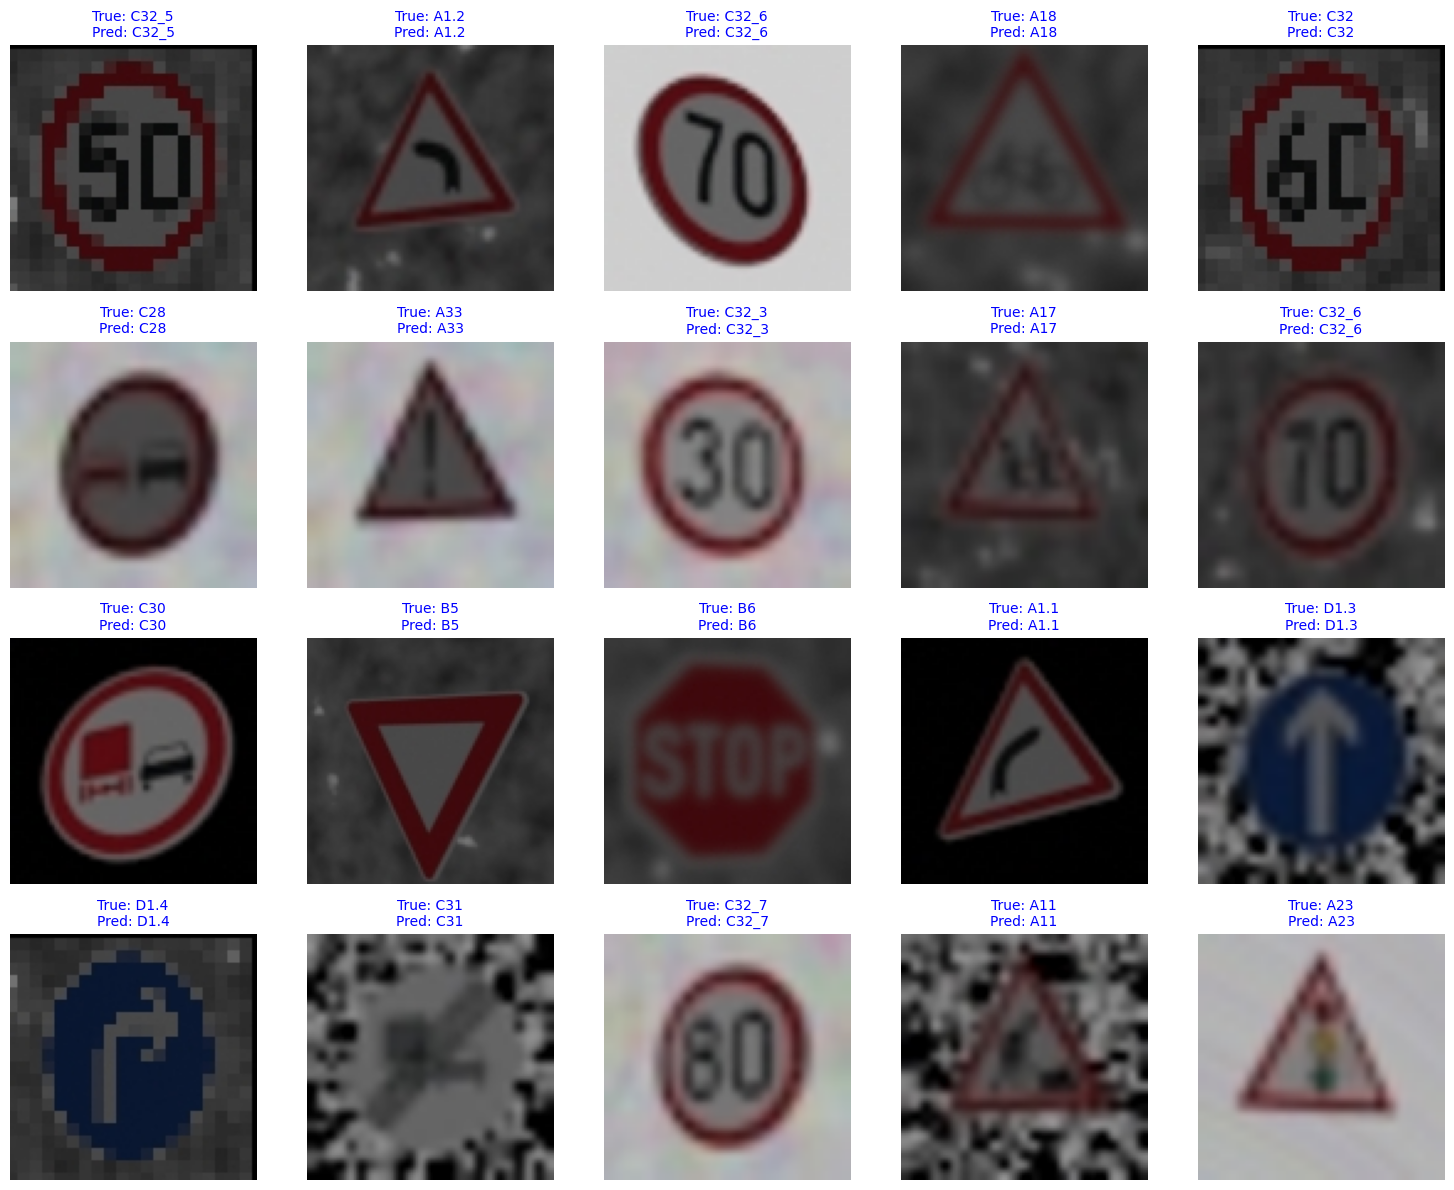

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def display_collage_with_labels(images, true_labels, predicted_labels, class_labels, num_cols=4):
    """
    Display a collage of images with true and predicted labels.

    :param images: Array of images
    :param true_labels: Array of true labels
    :param predicted_labels: Array of predicted labels
    :param class_labels: Dictionary mapping label indices to class names
    :param num_cols: Number of columns in the collage
    """
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows needed

    plt.figure(figsize=(num_cols * 3, num_rows * 3))  # Set figure size dynamically

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].astype('uint8'))  # Display the image
        true_label = class_labels[str(true_labels[i])]
        predicted_label = class_labels[str(predicted_labels[i])]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10, color='blue')
        plt.axis('off')  # Remove axes for cleaner display

    plt.tight_layout()
    plt.show()

# Number of samples to visualize
num_samples = 20
num_cols = 5  # Set number of columns in the collage

# Randomly select images from the test set
indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test[indices]
true_labels = labels[indices]
predicted_labels = pred[indices]

# Display the collage
display_collage_with_labels(sample_images, true_labels, predicted_labels, class_labels, num_cols=num_cols)


In [68]:
from sklearn.metrics import classification_report
# Classification report
report = classification_report(labels, pred, target_names=[str(i) for i in range(38)])

print(report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       216
           1       1.00      1.00      1.00       216
           2       1.00      1.00      1.00       216
           3       1.00      1.00      1.00       216
           4       1.00      1.00      1.00       216
           5       1.00      1.00      1.00       216
           6       1.00      1.00      1.00       216
           7       1.00      1.00      1.00       216
           8       1.00      1.00      1.00       216
           9       1.00      1.00      1.00       216
          10       1.00      1.00      1.00       216
          11       1.00      1.00      1.00       216
          12       1.00      1.00      1.00       216
          13       1.00      1.00      1.00       216
          14       1.00      1.00      1.00       216
          15       1.00      1.00      1.00       216
          16       1.00      1.00      1.00       216
          17       1.00    

## Testing model on real world data

In [74]:
import numpy as np
import matplotlib.pyplot as plt

def display_collage_with_labels(images, true_labels, predicted_labels, class_labels, confidences, num_cols=4):
    """
    Display a collage of images with true labels, predicted labels, and prediction confidence.

    :param images: Array of images
    :param true_labels: Array of true labels
    :param predicted_labels: Array of predicted labels
    :param class_labels: Dictionary mapping label indices to class names
    :param confidences: Array of prediction confidence scores (same order as predicted labels)
    :param num_cols: Number of columns in the collage
    """
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows needed

    plt.figure(figsize=(num_cols * 3, num_rows * 3))  # Set figure size dynamically

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].astype('uint8'))  # Display the image
        true_label = class_labels[str(true_labels[i])]
        predicted_label = class_labels[str(predicted_labels[i])]
        confidence = confidences[i]  # Get the confidence for the prediction
        plt.title(f"True: {true_label}\nPred: {predicted_label} ({confidence*100:.1f}%)", fontsize=10, color='blue')
        plt.axis('off')  # Remove axes for cleaner display

    plt.tight_layout()
    plt.show()

In [77]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

model = tf.keras.models.load_model(r"D:\dataset\structured_dataset_38_classes\finnish_traffic_sign_classifier_38_classes_old_dataset.keras")

# Root directory containing class-labeled subdirectories
root_dir = r'C:\Users\ali\workspace\jamk_thesis\thesis_work\creating_new_dataset\real_world_croped_images_dataset'

# Get the list of class names (subdirectory names)
classes = os.listdir(root_dir)

class_name_to_ids = {class_name: int(idx) for idx, class_name in class_labels.items()}

image_paths = []
labels = []

# Loop over each class directory
for class_name in classes:
    class_dir = os.path.join(root_dir, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                if class_name in class_name_to_ids:
                    image_path = os.path.join(class_dir, filename)
                    image_paths.append(image_path)
                    labels.append(class_name_to_ids[class_name])

data = []
sample_imgs = []

# Use GPU if available
with tf.device('/GPU:0'):
    for img_path in image_paths:
        image = Image.open(img_path)
        image = image.convert("RGB")
        sample_imgs.append(image.resize((100, 100)))
        image = image.resize((100, 100))
        data.append(np.array(image))

X_test = np.array(data)
X_test_disp = np.array(sample_imgs)
y_true = np.array(labels)
print("Sample Images Count: ", len(sample_imgs))

Sample Images Count:  39


In [78]:
with tf.device('/GPU:0'):
    predictions = model.predict(X_test)
    pred = np.argmax(predictions, axis=-1)
    pred_conf = np.max(predictions, axis=-1)

accuracy = accuracy_score(y_true, pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Model Accuracy: 35.90%


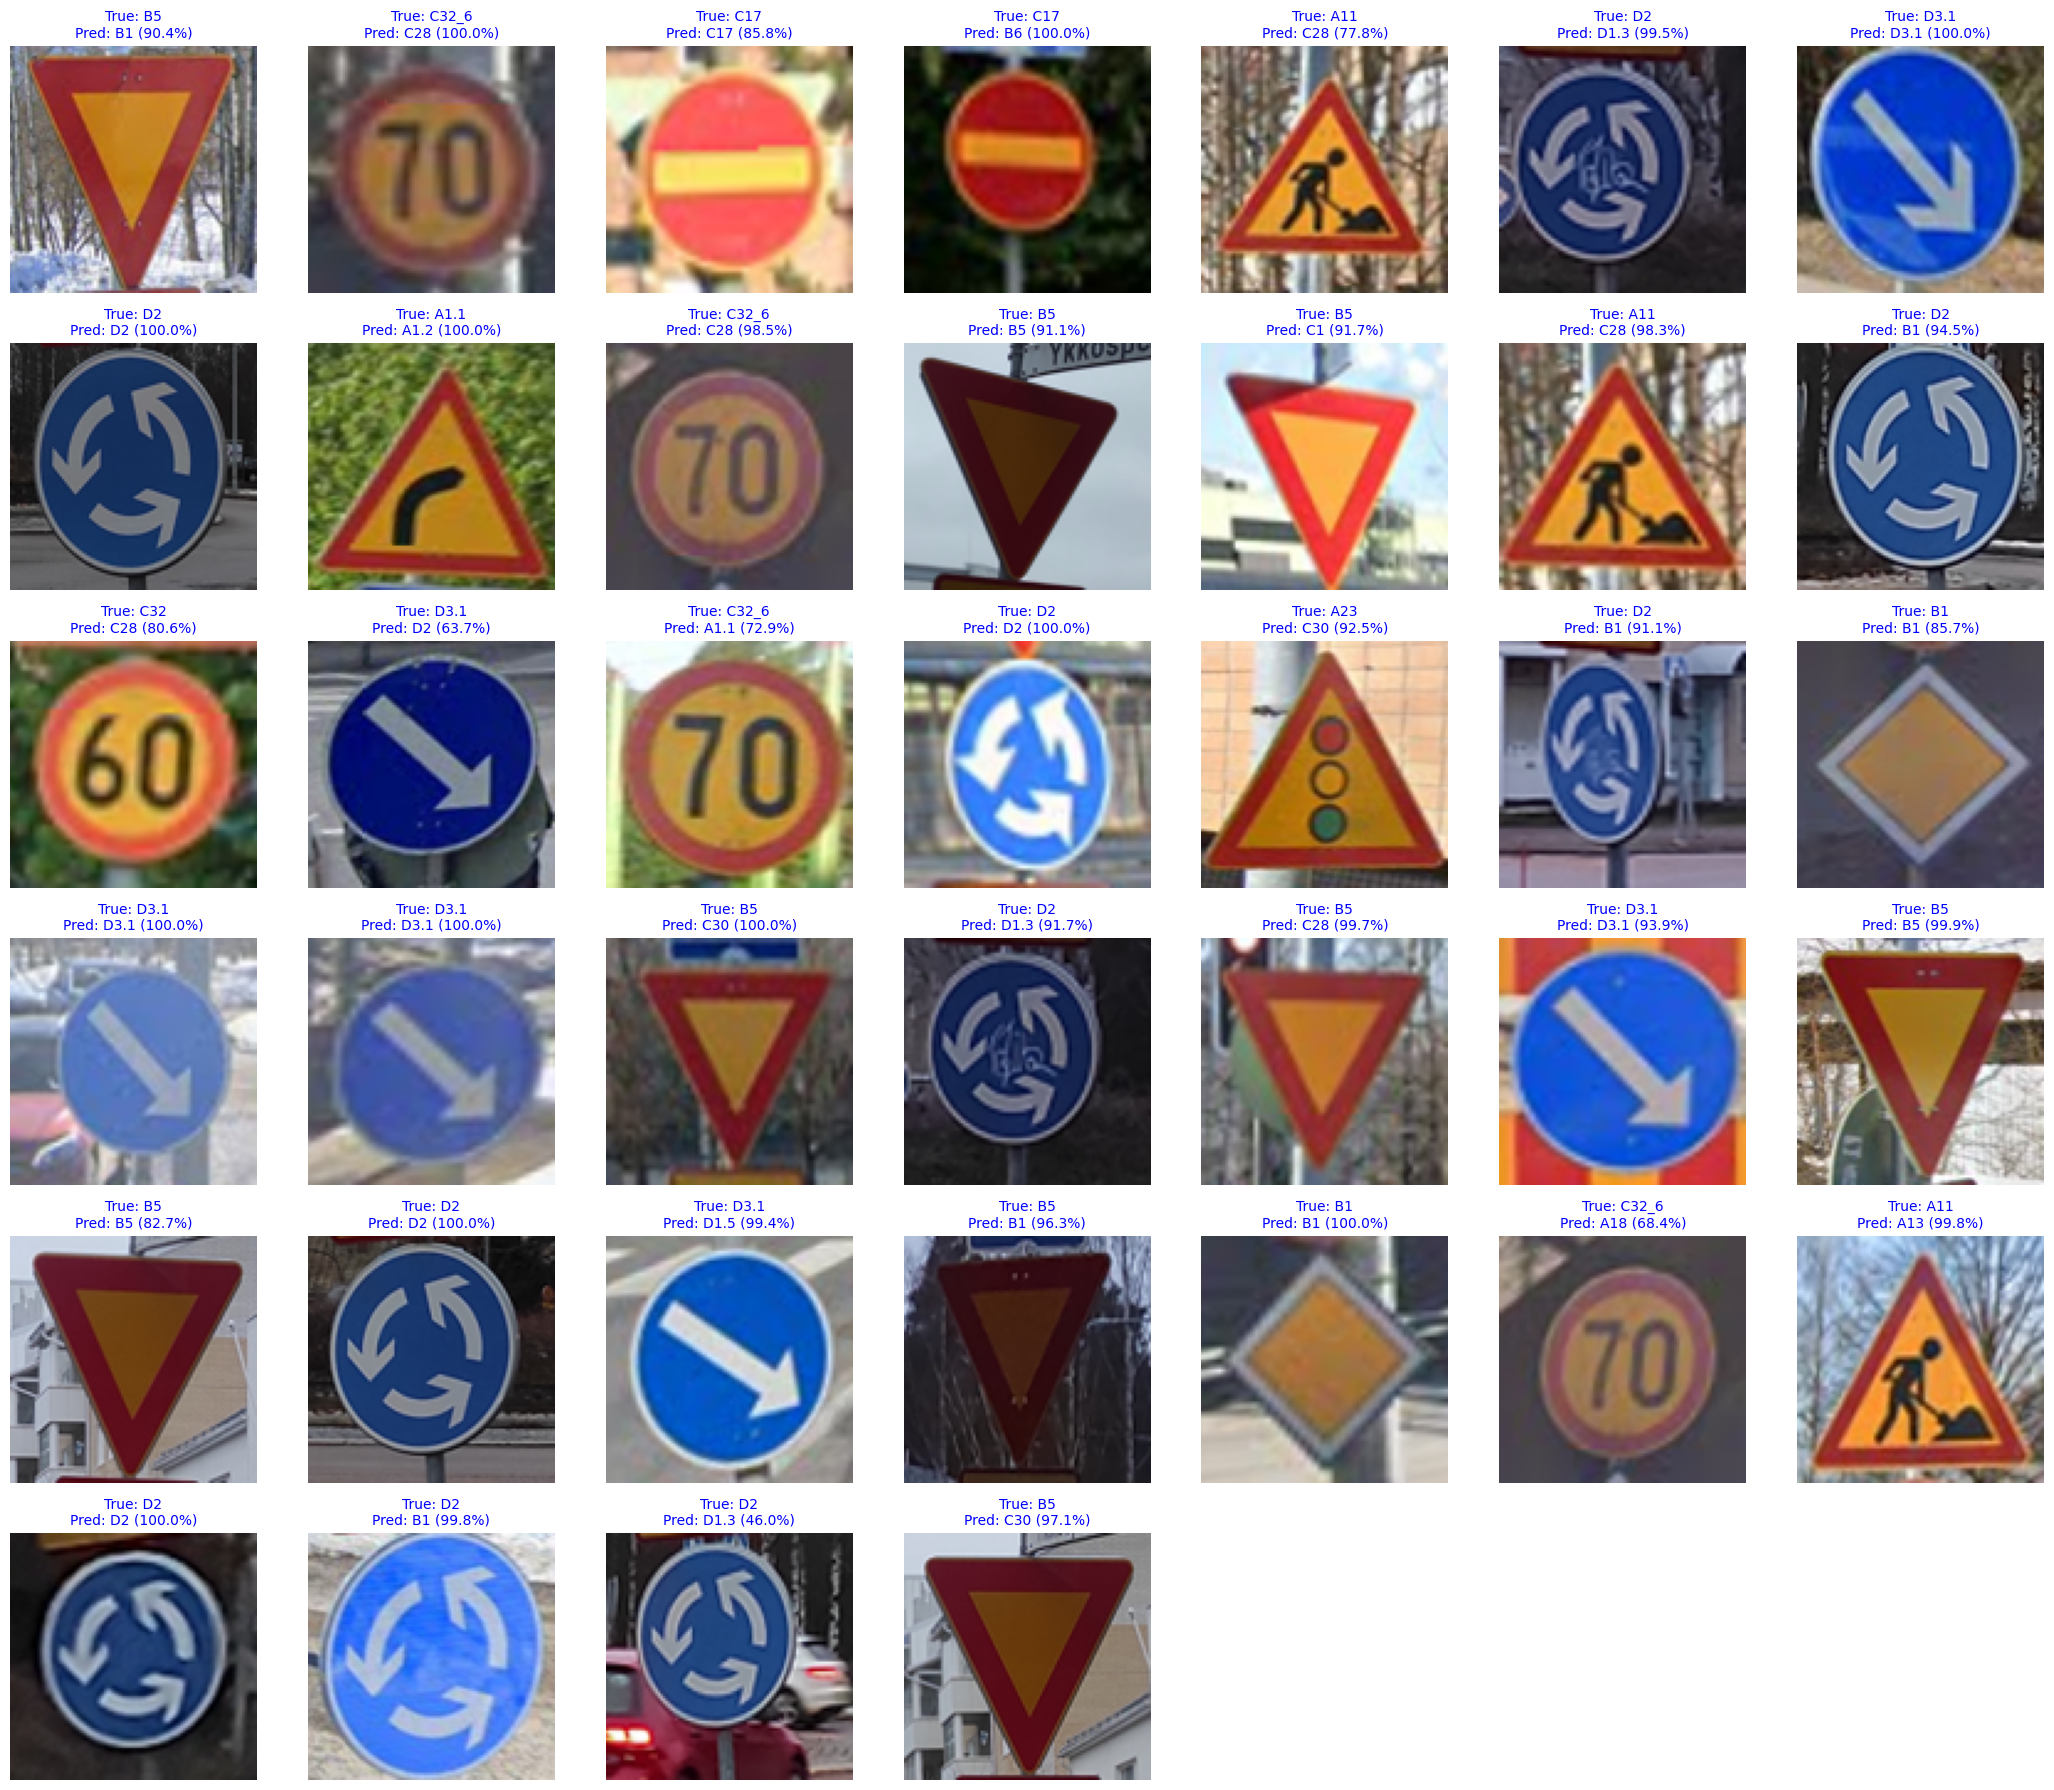

In [79]:
# Number of samples to visualize
num_samples = 39

# Randomly select samples from the test set
indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test_disp[indices]
true_labels = y_true[indices]
predicted_labels = pred[indices]
confidences = pred_conf[indices]

num_cols = 7
# Display the collage
display_collage_with_labels(sample_images, true_labels, predicted_labels, class_labels, confidences, num_cols=num_cols)